In [15]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [16]:
# Đọc file dữ liệu
df = pd.read_csv("C:\\Users\\ADMIN\\Desktop\\VTB.csv")

df = df[['Price','Low']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df1 = df
# Split the data into training, testing, and validation
train_size = int(0.9 * len(df))
test_size = len(df1) - train_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

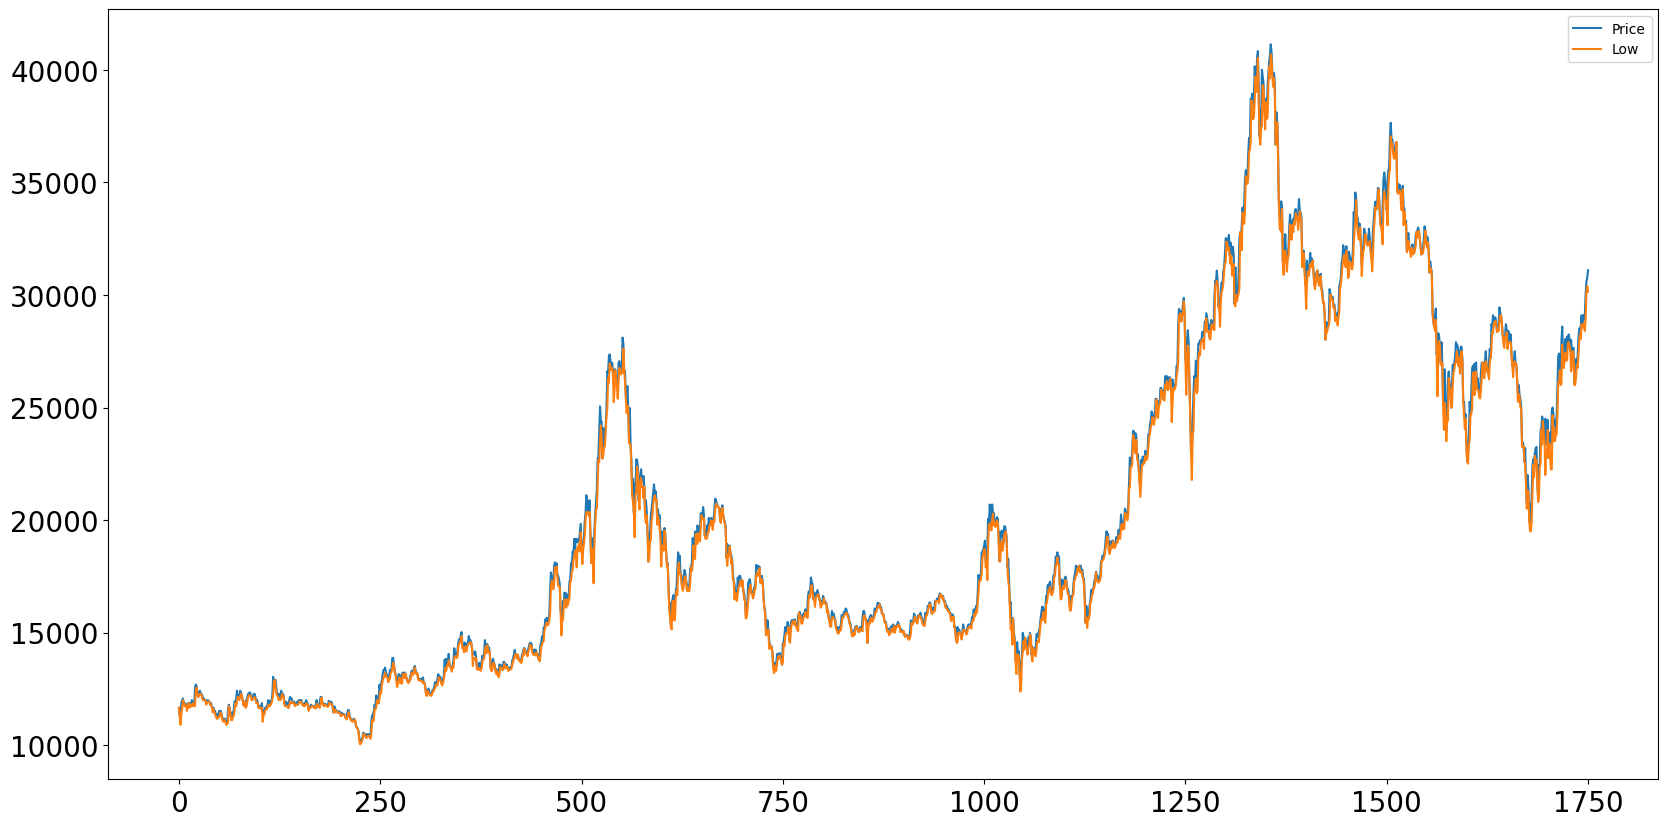

In [17]:
# Xem lại dataset
df.plot(figsize=(20, 10), fontsize=20)
plt.show()

In [18]:
# Tìm m thích hợp
# Dùng adf để kiểm tra xem dataset có stationary hay chưa
from statsmodels.tsa.stattools import adfuller
adfuller(df['Price'])

(-1.2482487299115146,
 0.6525038496876456,
 1,
 1749,
 {'1%': -3.4340943816187823,
  '5%': -2.8631939359068803,
  '10%': -2.5676505066098376},
 26447.68585277919)

In [19]:
# Vì dataset chưa stationary nên ta thực hiện diff()
df_diff = df1['Price'].diff().dropna()

In [20]:
# Tiếp tục dùng adf để kiểm tra xem p value có < 0.05 ko
adfuller(df_diff)

(-43.48255524609407,
 0.0,
 0,
 1749,
 {'1%': -3.4340943816187823,
  '5%': -2.8631939359068803,
  '10%': -2.5676505066098376},
 26432.797064761224)

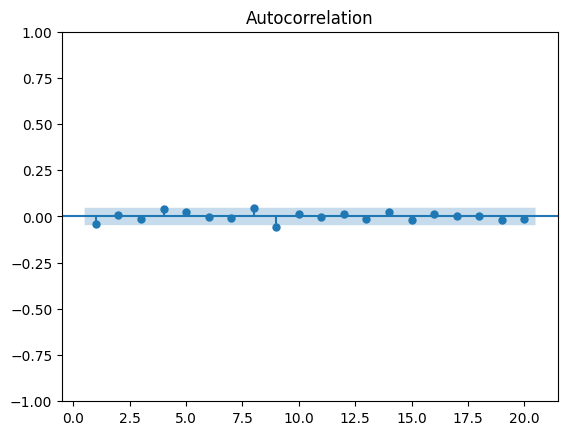

In [21]:
# Sau khi dataset đã stationary vẽ acf để tìm m
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_diff, lags = 20 , zero = False)
plt.show()

In [22]:
df

,Price,Low
0,11656,11656
1,11311,11242
2,11104,10897
3,11862,11380
4,12000,11587
...,...,...
1746,29100,28400
1747,30000,28900
1748,30600,30100
1749,30750,30400


In [23]:
# Tạo y_train, x_train
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])
# Dùng auto_arima để tìm thông số thích hợp
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = True, m =5)

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=23955.678, Time=3.16 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=23959.139, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=23960.677, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=23960.802, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=23957.539, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=23954.922, Time=2.31 sec
 ARIMA(2,1,2)(0,0,0)[5] intercept   : AIC=23955.740, Time=1.40 sec
 ARIMA(2,1,2)(0,0,2)[5] intercept   : AIC=23956.472, Time=3.95 sec


In [ ]:
# Dùng SARIMAX để train model
from statsmodels.tsa.statespace.sarimax import SARIMAX
model1 = SARIMAX(y_train, exog = np.array(train_data['Price']), order=(2,1,2), seasonal_order=(1, 0, 0, 5))
model_fit = model1.fit()

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Quá trình test
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
exg = np.array(test_data['Low'])
y_pred_test = model_fit.predict(start=len(y_train), end=len(y_test)+len(y_train)-1, exog=exg)
y_pred_test

array([19050., 18600., 20700., 21250., 21500., 20150., 20100., 22000.,
       22300., 22100., 22250., 22350., 22000., 21450., 20950., 20500.,
       19800., 20300., 21700., 21750., 20500., 20350., 19950., 20800.,
       19800., 18850., 18700., 19600., 20150., 21050., 21150., 21350.,
       22100., 21500., 20700., 22100., 22350., 22450., 22100., 22350.,
       21650., 21950., 22600., 22800., 22950., 22550., 22450., 22950.,
       23000., 23000., 22800., 22700., 22750., 23250., 24300., 24500.,
       24850., 24750., 25100., 24850., 25100., 25000., 24900., 24800.,
       25050., 25650., 25350., 25300., 25000., 25050., 24700., 24300.,
       24800., 25400., 25100., 24050., 24650., 24400., 24600., 24650.,
       24350., 23900., 22650., 23100., 23000., 22500., 22800., 22450.,
       21600., 21650., 21750., 21450., 21450., 20250., 20400., 20150.,
       19700., 19500., 19200., 18600., 19000., 17950., 16750., 15750.,
       15850., 15900., 16950., 17450., 17300., 17500., 16900., 16900.,
      

In [ ]:
# Quá trình tạo index predict 30 ngày tiếp theo
# Dùng thuật toán LR để tìm giá trị Low cho 30 ngày tiếp theo
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

ln_model.fit(np.array(train_data.index).reshape(-1,1), train_data['Price'])

last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Dự đoán giá trị price 30 ngày tiếp theo
price_next_30_days = ln_model.predict(x_next_30_days)

# Predict prices for the next 30 days
y_next_30_days = model_fit.predict(start=len(x_train), end = len(x_train)+ len(x_next_30_days)-1, exog=price_next_30_days)
# Print the predicted closing prices for the next 30 days
print('Predicted prices for the next 30 days:')
print(y_next_30_days)

Predicted prices for the next 30 days:
[25279.00585882 25289.71732838 25300.42879794 25311.14026749
 25321.85173705 25332.56320661 25343.27467616 25353.98614572
 25364.69761527 25375.40908483 25386.12055439 25396.83202394
 25407.5434935  25418.25496306 25428.96643261 25439.67790217
 25450.38937173 25461.10084128 25471.81231084 25482.5237804
 25493.23524995 25503.94671951 25514.65818907 25525.36965862
 25536.08112818 25546.79259774 25557.50406729 25568.21553685
 25578.92700641 25589.63847596]


In [ ]:
# Đánh giá độ chính xác thuật toán với MAPE
# RMSE
test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))
print('Testing RMSE:', test_rmse)

# MAPE (thay thế MSE bằng MAPE)
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print('Testing MAPE:', test_mape)

# MAE
test_mae = np.mean(np.abs(y_pred_test - y_test))
print('Testing MAE:', test_mae)


Testing RMSE: 594.5060975297057
Testing MAPE: 2.0511673612645507
Testing MAE: 426.70454545454544


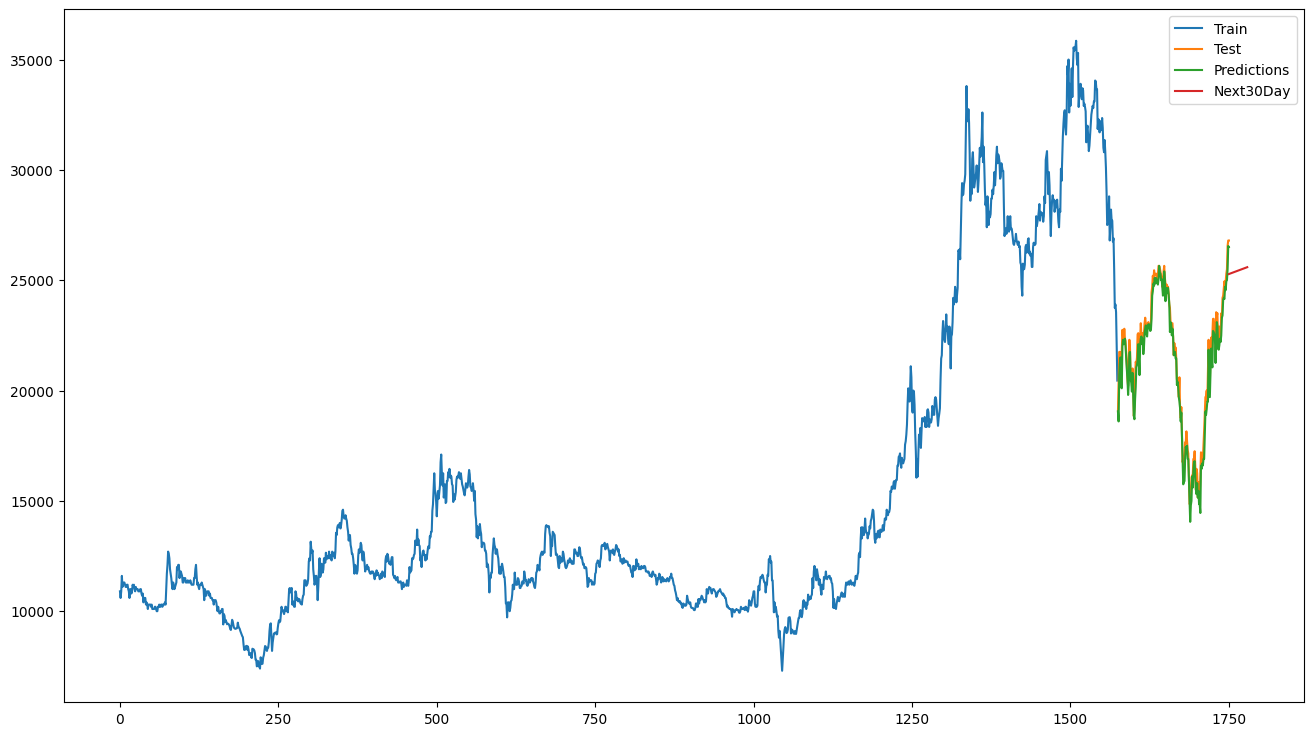

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred_test)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()